In [1]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern

from advopt import *

SEED = 999111

/mnt/mborisyak/opt/pyenv/versions/3.6.6/envs/py3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
task = tasks.XOR()

DATA_ROOT=os.path.join(
    os.environ.get('DATA_ROOT', './'),
    'RAO'
)

repeat = 100
budget = 64 * 1024

In [3]:
results = experiment(
    root=DATA_ROOT,
    task=task,
    models=['JSD-GBDT', 'log-pJSD-GBDT', 'lin-pJSD-GBDT'],
    optimizer=bayesian_optimization(
        base_estimator=GaussianProcessRegressor(
            kernel=Matern(length_scale=1, length_scale_bounds=(1e-2, 1e+2)),
            alpha=1e-4
        ),
        n_initial_points=5,
        metric=adjusted(verbose=True)
    ),
    budget=budget,
    repeat=repeat,
    progress=tqdm,
    devices=['cpu'] * 10,
    seed=SEED,
    logs='./logs',
)

In [4]:
### change of order
results = {
    'JSD-GBDT' : results['JSD-GBDT'],
    'lin-pJSD-GBDT' : results['lin-pJSD-GBDT'],
    'log-pJSD-GBDT' : results['log-pJSD-GBDT'],
}

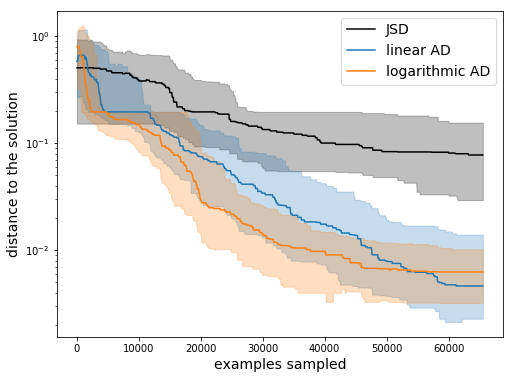

In [5]:
plt.figure(figsize=(8, 6))
plot_convergence(
    results, distance_to([0.0]), budget=budget, qs=(0.25, ),
    properties={
        'JSD-GBDT' : dict(color='black', label='JSD'),
        'lin-pJSD-GBDT' : dict(color=plt.cm.tab10(0), label='linear AD'),
        'log-pJSD-GBDT' : dict(color=plt.cm.tab10(1), label='logarithmic AD')
    },
    individual=False
)
plt.yscale('log')
plt.xlabel('examples sampled', fontsize=14)
plt.ylabel('distance to the solution', fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.savefig(os.path.join(
    DATA_ROOT, 
    '%s-%d-BO-GBDT.pdf' % (task.name(), budget)
))